In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 2

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 1000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 5.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:1' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.0005,
            'metric' : "EO",
            'lambda': 0.5,
            'lambda_old': 0.0,
            
              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=2_epoch=15_lr=0.001_tau=5.0_alpha=0.0005_lmbd_0.5_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
benchmark.mnist_train.sensitives

array([5, 0, 4, ..., 7, 6, 8])

In [5]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [6]:
target_label = 0
incremental_step = 1
# cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
to_pil_image(unnormalize(cat_img), mode="RGB")

In [7]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8212217926818304, 'loss': 0.0023008350643987634, 'std': 0.0379618807875573, 'EER': -1, 'EO': [0.27111984282907664, 0.43157894736842106], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6486506049012511, 'classwise_accuracy': {0: array([842, 980]), 1: array([ 889, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 471, 1: 565}, 'class_pred_count_s1': {0: 617, 1: 462}, 'class_pred_count': {0: 1088, 1: 1027}, 'count_s0': 1036, 'count_s1': 1079, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.9089409332014744, 'loss': 0.001165850619052319, 'std': 0.01554886271689293, 'EER': -1, 'EO': [0.21228070175438596, 0.14538310412573674], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.8211680970599387, 'classwise_accuracy': {1: array([1014, 1135]), 0: array([906, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 565, 0: 471}, 'class_pred_count_s1': {0: 556, 1: 523}, 'class_pre

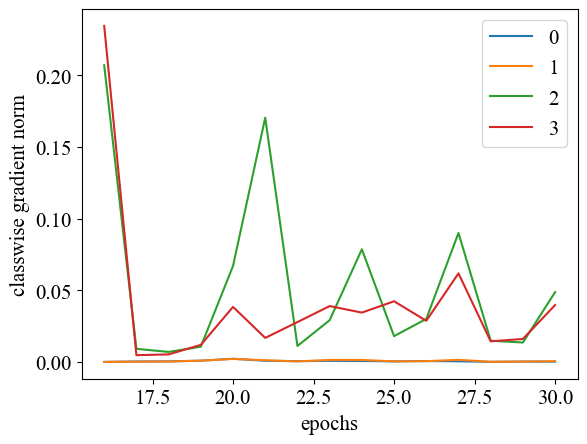

---------------------------- Task 3 -----------------------
losses=tensor([[2.7271e-04, 2.5122e-04, 8.3883e-02, 7.6833e-02, 1.0173e+01, 1.1345e+01,
         3.8393e-03, 7.0617e-03, 1.9648e-01, 1.4335e-01, 1.0348e+01, 1.1819e+01]])
Elapsed time(grad):3.901
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):7.072
Fairness:[ 0.00816916 -0.00598307  0.03386307  0.02993499  0.02372226  0.05120246]
Current class expected loss:[ 0.          0.          0.          0.         -1.81176627 -2.17653863]
len(updated_seq_indices)=11263
Elapsed time(etc):0.196
[31] Eval metrics for task 1 >> {'accuracy': 0.9477097006203362, 'loss': 0.0007554044361373775, 'std': 0.0038321495999280586, 'EER': -1, 'EO': [0.06477255084614197, 0.07535277948101893], 'DP': -1, 'accuracy_s0': 0.9835428292279653, 'accuracy_s1': 0.9134801640643849, 'classwise_accuracy': {1: array([1080, 1135]), 0: array([925, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 556, 0: 463, 4: 2, 2: 8, 5: 5, 3: 2}, '

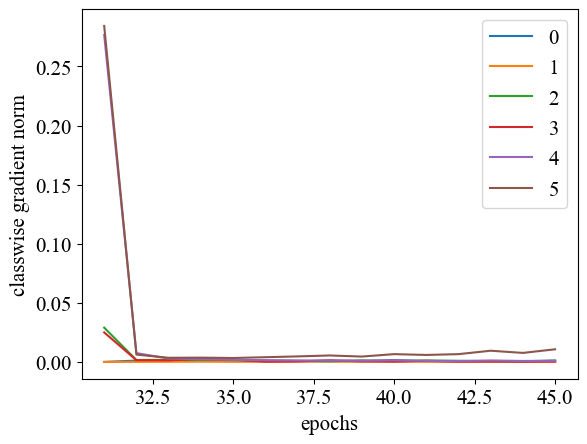

---------------------------- Task 4 -----------------------
losses=tensor([[6.9420e-04, 6.0908e-04, 1.0928e-03, 2.4422e-03, 1.8039e-03, 9.4446e-03,
         1.2173e+01, 8.4622e+00, 3.9332e-03, 5.0519e-03, 4.1293e-03, 1.0300e-02,
         1.5634e-01, 4.0060e-01, 1.4355e+01, 1.3877e+01]])
Elapsed time(grad):3.558
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.753
Fairness:[-0.00883904  0.00243955  0.00181541 -0.00464118  0.01465087  0.04976123
  0.17384132  0.36421975]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
 -2.60712804 -2.02633269]
len(updated_seq_indices)=12183
Elapsed time(etc):0.19
[46] Eval metrics for task 1 >> {'accuracy': 0.9069922682729479, 'loss': 0.001583658542757057, 'std': 0.008313854176031643, 'EER': -1, 'EO': [0.1418413289861823, 0.09766037232156632], 'DP': -1, 'accuracy_s0': 0.9679706142081431, 'accuracy_s1': 0.8482197635542688, 'classwise_accuracy': {1: array([1020, 1135]), 0: array([89

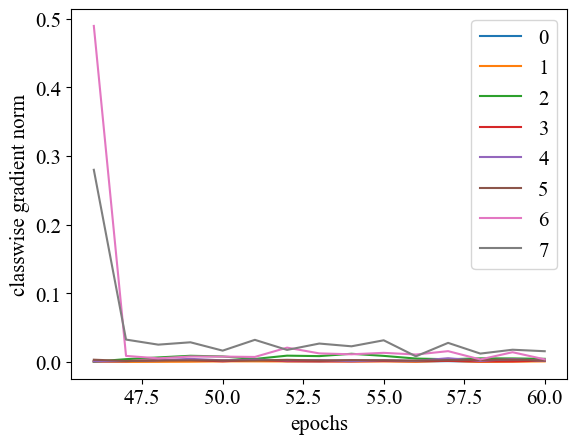

---------------------------- Task 5 -----------------------
losses=tensor([[1.7205e-03, 8.4505e-04, 1.8565e-02, 2.9285e-03, 3.6671e-03, 5.7147e-03,
         5.8820e-02, 3.9559e-02, 1.4180e+01, 1.8762e+01, 1.1652e-02, 9.8550e-03,
         6.3199e-02, 8.3538e-03, 2.0870e-02, 4.2730e-02, 1.5400e-01, 1.0259e-01,
         1.4596e+01, 1.6468e+01]])
Elapsed time(grad):3.438
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.484
Fairness:[ 0.00231811  0.00227636  0.00634904 -0.00218604 -0.00292343  0.00062604
  0.01101025 -0.0153714   0.02681614 -0.11204841]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
  0.          0.         -2.93293393 -3.7279688 ]
len(updated_seq_indices)=11800
Elapsed time(etc):0.182
[61] Eval metrics for task 1 >> {'accuracy': 0.8974826935179359, 'loss': 0.0019676848647160452, 'std': 0.011768407803650127, 'EER': -1, 'EO': [0.14237149566820584, 0.08907002018320131], 'DP': -1, 'accuracy_s0': 0.9568

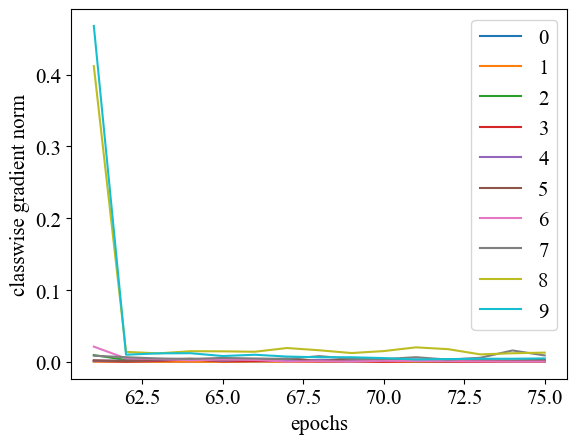

final avg-acc 0.8227280537601676
final avg-forget 0.15987632878184324


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")

67.4155	63.7579	57.196	50.8194	
96.6086	108.0152	160.2296	178.3288	
4.2626	3.5991	3.1005	3.5334	
188.1495	198.3751	238.6554	256.7618	

In [ ]:
losses, *_ = algorithm.get_loss_grad_all(params['num_tasks']) 
algorithm.true_loss[params['num_tasks']][params['epochs_per_task']] = losses

num_epochs = params['epochs_per_task']
for task in range(2, params['num_tasks']):
    algorithm.true_loss[task][num_epochs] = algorithm.true_loss[task+1][0]

num_class_per_task = 2
t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = list()
    groupwise_expected_loss[i] = list()
    for j in range(2):
        groupwise_true_loss[i].append(dict())
        groupwise_expected_loss[i].append(dict())


for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            if i < num_class_per_task*task:
                groupwise_true_loss[i][0][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i][0][(task-1)*num_epochs+epoch] = el
            else:
                groupwise_true_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = el

            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][0][ce], end='\t')
    print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][1][ce], end='\t')
    print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][0][ce], end='\t')
    print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][1][ce], end='\t')
    print()


In [12]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"DP:{np.mean(metric_manager_callback.meters['DP'].compute_overall())}")
print(f"EO:{np.mean(metric_manager_callback.meters['EO'].compute_overall())}")


accuracy:0.9025666915611618
DP:0.008905489127881338
EO:0.11932167054793288
